In [2]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.signal import find_peaks
import os
from scipy.stats import norm, chisquare
from sklearn.mixture import GaussianMixture
import pandas as pd

# Enable implicit multi-threading (optional)
ROOT.ROOT.EnableImplicitMT()

%matplotlib widget

In [3]:
DATA = {}
CUTS = {}

for file in os.listdir("./data/energies"):
    if not file.endswith(".root"):
        continue

    f = ROOT.TFile.Open("./data/energies/"+file)

    tree = f.Get("sec_electrons")
    if not tree:
        print("Tree not found.")
        exit()

    df = ROOT.RDataFrame(tree)

    Z_branch = 'z'
    z_arr = np.array(df.AsNumpy([Z_branch])[Z_branch]) * 10 # Convert to mm

    energy_mev = int(file.split('/')[-1].split('MeV')[0])
    DATA[energy_mev] = [np.array(z2) for z2 in z_arr]

    tree = f.Get("events")

    df = ROOT.RDataFrame(tree)

    t_branch = 'theta'
    thetas = np.radians(np.array(df.AsNumpy([t_branch])[t_branch]))

    CUTS[energy_mev] = 3*np.cos(thetas)
    CUTS[f'{energy_mev}_thetas'] = thetas

CUTS = pd.DataFrame(CUTS)
DATA = pd.DataFrame(DATA)


ValueError: All arrays must be of the same length

In [ ]:
CUTS[10]

0       3.0
1       3.0
2       3.0
3       3.0
4       3.0
       ... 
9995    3.0
9996    3.0
9997    3.0
9998    3.0
9999    3.0
Name: 10, Length: 10000, dtype: float64

AttributeError: 'list' object has no attribute 'explode'

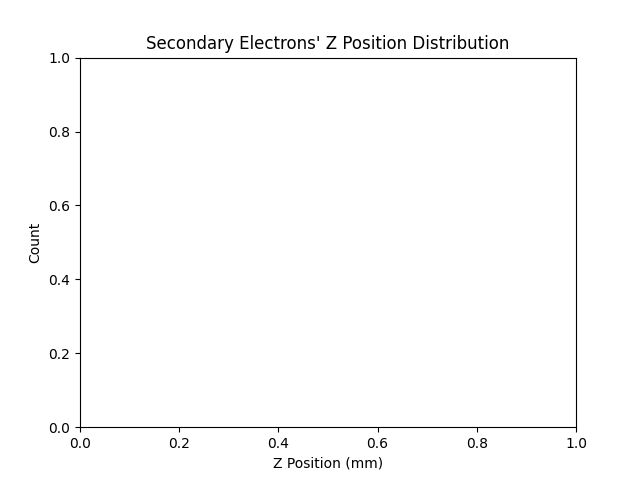

In [6]:
plt.figure()
plt.title("Secondary Electrons' Z Position Distribution")
plt.xlabel("Z Position (mm)")
plt.ylabel("Count")

d = DATA[5].explode()

plt.hist(d, bins=np.linspace(-6,3,20), alpha=0.5, label=f"{10} MeV")

plt.legend()
plt.grid()
plt.show()

In [ ]:
np.linspace(-6)

[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[0.83692505 0.51295811 0.29952663 ... 0.79112493 1.27028451 0.32494634] [0.7655159  0.59345416 0.45066468 ... 0.74322271 0.95626969 0.46974322]
[1.44322646e+00 1.16483092e-01 1.40276330e-01 ... 2.76864985e-01
 3.67886836e-01 1.64246968e-06] [1.025204   0.27957681 0.30701071 ... 0.43299852 0.50044099 0.00104641]
[0.08838858 1.49618658 0.48326758 ... 0.00558988 0.23229469 0.15374743] [0.24334619 1.04572914 0.57551741 ... 0.06105524 0.39611109 0.32153684]


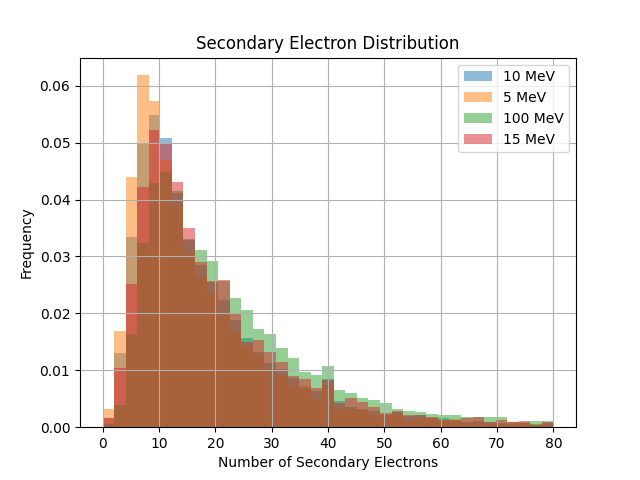

In [7]:
plt.figure()

for k in DATA.keys():
    n_elec = np.array([len(z2[np.argwhere((0<z2) & (z2<CUTS[k][i]))]) for i, z2 in enumerate(DATA[k])])
    print(3-CUTS[k], CUTS[f'{k}_thetas'])

    plt.hist(n_elec, bins=np.linspace(0,80,40), alpha=0.5, label=f"{k} MeV", density=True)


plt.title('Secondary Electron Distribution')
plt.grid()
plt.ylabel('Frequency')
plt.xlabel('Number of Secondary Electrons')

plt.legend()

/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_3447/1549789140.py:9: RuntimeWarning: invalid value encountered in scalar power
  return (x ** (a - 1)) * np.exp(-x / theta) / (gamma(a) * theta ** a)


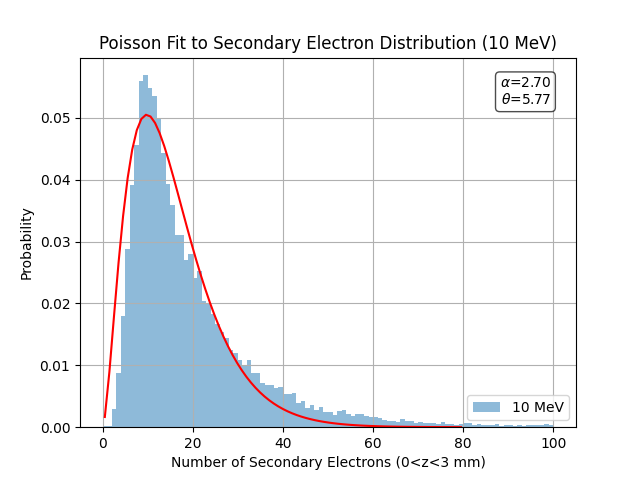

In [4]:
from scipy.stats import poisson


n_elec_10 = np.array([len(z2[np.argwhere((0<z2) & (z2<CUTS[10][i]))]) for i, z2 in enumerate(DATA[10])])


# Define Poisson PMF for fitting
def func(x, a, theta):
    return (x ** (a - 1)) * np.exp(-x / theta) / (gamma(a) * theta ** a)

# Histogram data
counts, bins = np.histogram(n_elec_10, bins=np.linspace(0, 80, 80))
counts = counts / counts.sum()  # Normalize to get probability
x_centers = (bins[:-1] + bins[1:]) / 2



# Fit Poisson distribution using previously defined poisson_pmf
popt, pcov = curve_fit(func, x_centers, counts, p0=[2, 1])

plt.figure()
plt.hist(n_elec_10, bins=np.arange(0, 101, 1), alpha=0.5, label='10 MeV', density=True)
plt.plot(x_centers, func(x_centers, *popt), 'r-')

plt.text(
    0.95, 0.95,
    f"$\\alpha$={popt[0]:.2f}\n$\\theta$={popt[1]:.2f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)

plt.xlabel('Number of Secondary Electrons (0<z<3 mm)')
plt.ylabel('Probability')
plt.title('Poisson Fit to Secondary Electron Distribution (10 MeV)')
plt.legend()
plt.grid()
plt.show()


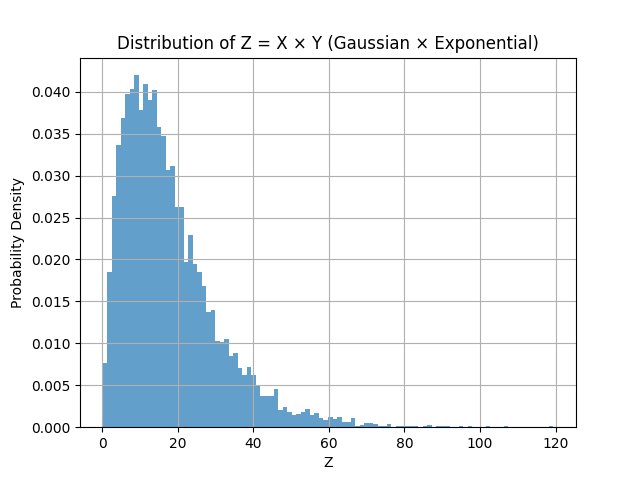

In [8]:
# Parameters
sigma = 1
beta = 1
alpha = 2
N = 10000

# Sample
X = np.random.normal(9, sigma, N)
Y = np.random.gamma(alpha, beta, N)
Z = X * Y

# Plot
plt.figure()
plt.hist(Z, bins=100, density=True, alpha=0.7)
plt.title("Distribution of Z = X × Y (Gaussian × Exponential)")
plt.xlabel("Z")
plt.ylabel("Probability Density")
plt.grid()
plt.show()

In [7]:
n_elec

array([ 83, 468,  28, ..., 274,  42,  71], shape=(5000,))

# Compare 3mm normalized 1.33 scaled vs 4mm

In [37]:
f = ROOT.TFile.Open("./data/energies/10MeV.root")

tree = f.Get("sec_electrons")
if not tree:
    print("Tree not found.")
    exit()

df = ROOT.RDataFrame(tree)

Z_branch = 'z'
z_arr = np.array(df.AsNumpy([Z_branch])[Z_branch]) * 10 # Convert to mm

DATA10 = [np.array(z2) for z2 in z_arr]

tree = f.Get("events")

df = ROOT.RDataFrame(tree)

t_branch = 'theta'
thetas = np.radians(np.array(df.AsNumpy([t_branch])[t_branch]))

CUTS10 = 3*np.cos(thetas)

n_elec_3 = np.array([len(z2[np.argwhere((0<z2) & (z2<CUTS10[i]))]) for i, z2 in enumerate(DATA10)])




In [38]:
f = ROOT.TFile.Open("./data/4mm_length.root")

tree = f.Get("sec_electrons")
if not tree:
    print("Tree not found.")
    exit()

df = ROOT.RDataFrame(tree)

Z_branch = 'z'
z_arr = np.array(df.AsNumpy([Z_branch])[Z_branch]) * 10 # Convert to mm

DATA10 = [np.array(z2) for z2 in z_arr]

tree = f.Get("events")

df = ROOT.RDataFrame(tree)

t_branch = 'theta'
thetas = np.radians(np.array(df.AsNumpy([t_branch])[t_branch]))

CUTS10 = 4*np.cos(thetas)

n_elec_4 = np.array([len(z2[np.argwhere((0<z2) & (z2<CUTS10[i]))]) for i, z2 in enumerate(DATA10)])




In [41]:
f = ROOT.TFile.Open("./data/9mm_length.root")

tree = f.Get("sec_electrons")
if not tree:
    print("Tree not found.")
    exit()

df = ROOT.RDataFrame(tree)

Z_branch = 'z'
z_arr = np.array(df.AsNumpy([Z_branch])[Z_branch]) * 10 # Convert to mm

DATA10 = [np.array(z2) for z2 in z_arr]

tree = f.Get("events")

df = ROOT.RDataFrame(tree)

t_branch = 'theta'
thetas = np.radians(np.array(df.AsNumpy([t_branch])[t_branch]))

CUTS10 = 9*np.cos(thetas)

n_elec_9 = np.array([len(z2[np.argwhere((0<z2) & (z2<CUTS10[i]))]) for i, z2 in enumerate(DATA10)])




In [53]:
f = ROOT.TFile.Open("./data/5mm_length.root")

tree = f.Get("sec_electrons")
if not tree:
    print("Tree not found.")
    exit()

df = ROOT.RDataFrame(tree)

Z_branch = 'z'
z_arr = np.array(df.AsNumpy([Z_branch])[Z_branch]) * 10 # Convert to mm

DATA10 = [np.array(z2) for z2 in z_arr]

tree = f.Get("events")

df = ROOT.RDataFrame(tree)

t_branch = 'theta'
thetas = np.radians(np.array(df.AsNumpy([t_branch])[t_branch]))

CUTS10 = 5*np.cos(thetas)

n_elec_5 = np.array([len(z2[np.argwhere((0<z2) & (z2<CUTS10[i]))]) for i, z2 in enumerate(DATA10)])




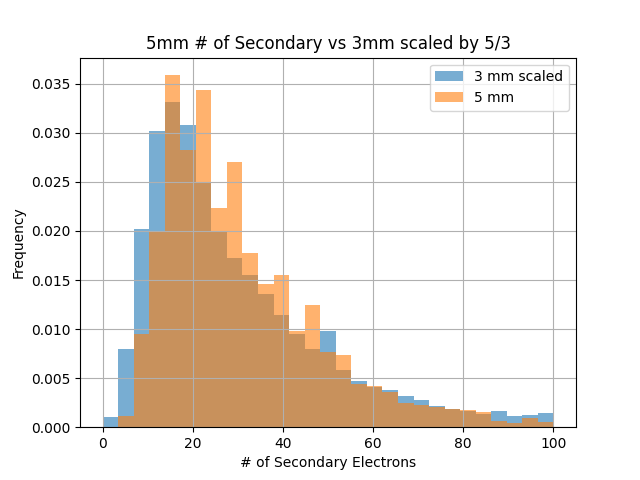

In [76]:
plt.figure()

bins = np.linspace(0,100,30)
# plt.hist(n_elec_3, bins=bins, density=True, alpha=0.6, label='3 mm')
plt.hist(n_elec_3*1.666, bins=bins, density=True, alpha=0.6, label='3 mm scaled')
# plt.hist(n_elec_4, bins=bins, density=True, alpha=0.6, label='4 mm')
plt.hist(n_elec_5, bins=bins, density=True, alpha=0.6, label='5 mm')
# plt.hist(n_elec_9, bins=bins, density=True, alpha=0.6, label='9 mm')
plt.title('5mm # of Secondary vs 3mm scaled by 5/3')
plt.xlabel('# of Secondary Electrons')
plt.ylabel('Frequency')
plt.grid()
plt.legend()

In [ ]:
f = ROOT.TFile.Open("./data/energies/10MeV.root")

tree = f.Get("clusters")
if not tree:
    print("Tree not found.")
    exit()

df = ROOT.RDataFrame(tree)

nc_branch = 'n_clusters'
ece_branch = 'ece'
n_arr = np.array(df.AsNumpy([nc_branch])[nc_branch]) 
ene_arr = np.array(df.AsNumpy([ece_branch])[ece_branch])

ene_arr = np.array(pd.DataFrame({1:[np.array(e) for e in ene_arr]})[1].explode())



<class 'numpy.ndarray'>


/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_24700/1898312507.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, hist_x, hist_counts, p0=p0)


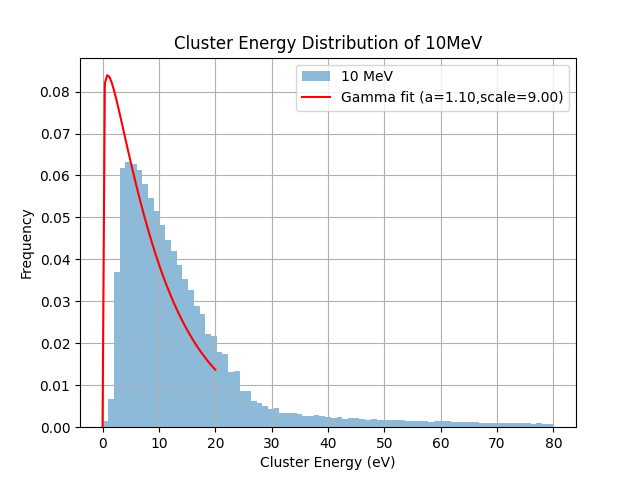

In [ ]:
from scipy.stats import expon
from scipy.stats import gamma as gamma_pdf
from scipy.special import gamma
from scipy.optimize import curve_fit

plt.figure()
# plt.hist(ene_arr-ene_arr.min(), bins=np.linspace(0, 80, 80), alpha=0.5, label='10 MeV', density=True)
plt.xlabel('Cluster Energy (eV)')
plt.ylabel('Frequency')
plt.title('Cluster Energy Distribution of 10MeV')
plt.grid()

fit_d = ene_arr-ene_arr.min()

# Fit gamma distribution to the data using scipy curve_fit

def func(x, alpha, theta):
    ret = (1 / (gamma(alpha) * theta**alpha)) * (x)**(alpha - 1) * np.exp(-(x) / theta)
    # ret[np.argwhere(x < mu)] = 0  # Ensure the function is zero for x < mu
    return ret

plt.hist(fit_d, bins=np.linspace(0, 80, 80), alpha=0.5, label='10 MeV', density=True)

# Histogram data for fitting
hist_counts, hist_bins = np.histogram(fit_d, bins=80, density=True)
hist_x = (hist_bins[:-1] + hist_bins[1:]) / 2



# Initial guess for parameters: a, loc, scale
p0 = [1.1, 9]

popt, pcov = curve_fit(func, hist_x, hist_counts, p0=p0)

# Plot the fitted gamma PDF
x = np.linspace(0, 20, 50)
plt.plot(x, func(x, *popt), 'r-', label=f'Gamma fit (a={popt[0]:.2f},scale={popt[1]:.2f})')
plt.legend()


In [19]:
func(0.1, *popt)

np.float64(0.0736490368007704)

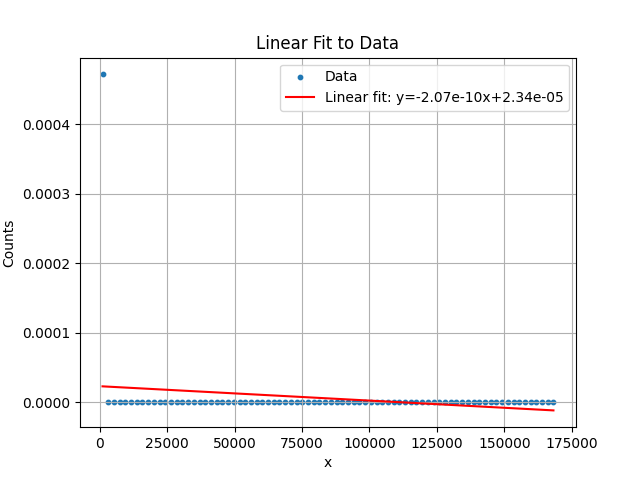

In [18]:
# Fit a linear model to (hist_x, hist_counts)
def linear_func(x, a, b):
    return a * x + b

# Use curve_fit to fit the linear model
lin_popt, lin_pcov = curve_fit(linear_func, hist_x, hist_counts)

# Plot the data and the linear fit
plt.figure()
plt.scatter(hist_x, hist_counts, label='Data', s=10)
plt.plot(hist_x, linear_func(hist_x, *lin_popt), 'r-', label=f'Linear fit: y={lin_popt[0]:.2e}x+{lin_popt[1]:.2e}')
plt.xlabel('x')
plt.ylabel('Counts')
plt.title('Linear Fit to Data')
plt.legend()
plt.grid()
plt.show()

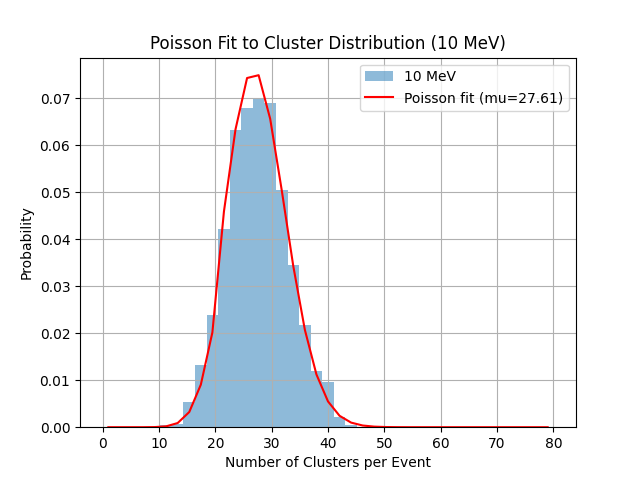

In [10]:
from scipy.optimize import curve_fit

plt.figure()
plt.hist(n_arr, bins=np.linspace(0, 80, 40), alpha=0.5, label='10 MeV', density=True)

# Define Poisson PMF for fitting
def poisson_pmf(x, mu):
    return (mu ** np.round(x).astype(int)) * np.exp(-mu) / gamma(np.round(x).astype(int) + 1)

# Histogram data
counts, bins = np.histogram(n_arr, bins=np.linspace(0, 80, 40))
counts = counts / counts.sum()  # Normalize to get probability
x_centers = (bins[:-1] + bins[1:]) / 2

# Fit Poisson distribution
popt, pcov = curve_fit(poisson_pmf, x_centers, counts, p0=[np.mean(n_arr)])

plt.plot(x_centers, poisson_pmf(x_centers, *popt), 'r-', label=f'Poisson fit (mu={popt[0]:.2f})')
plt.xlabel('Number of Clusters per Event')
plt.ylabel('Probability')
plt.title('Poisson Fit to Cluster Distribution (10 MeV)')
plt.legend()
plt.grid()
plt.show()

In [3]:
f = ROOT.TFile.Open("./data/energies/10MeV.root")

tree = f.Get("sec_electrons")
if not tree:
    print("Tree not found.")
    exit()

df = ROOT.RDataFrame(tree)

Z_branch = 'z'
z_arr = np.array(df.AsNumpy([Z_branch])[Z_branch]) * 10 # Convert to mm

energy_mev = int(file.split('/')[-1].split('MeV')[0])
DATA10 = [np.array(z2) for z2 in z_arr]

tree = f.Get("events")

df = ROOT.RDataFrame(tree)

t_branch = 'theta'
thetas = np.radians(np.array(df.AsNumpy([t_branch])[t_branch]))

CUTS10 = 3*np.cos(thetas)

In [78]:
n_elec_10 = np.array([len(z2[np.argwhere((0<z2) & (z2<CUTS10[i]))]) for i, z2 in enumerate(DATA10)])

counts, sides = np.histogram(n_elec_10, bins=np.arange(0, n_elec_10.max(), 1))

pdf = counts / counts.sum() 
cdf = np.cumsum(pdf)

n = int(5e3)
table = np.zeros(n)
cdf *= n

for i in range(len(cdf)-1):
    table[int(cdf[i]):int(cdf[i+1])] = i+1
table[-1] = len(pdf-1)

Text(0.5, 1.0, 'HEED vs Lookup Table')

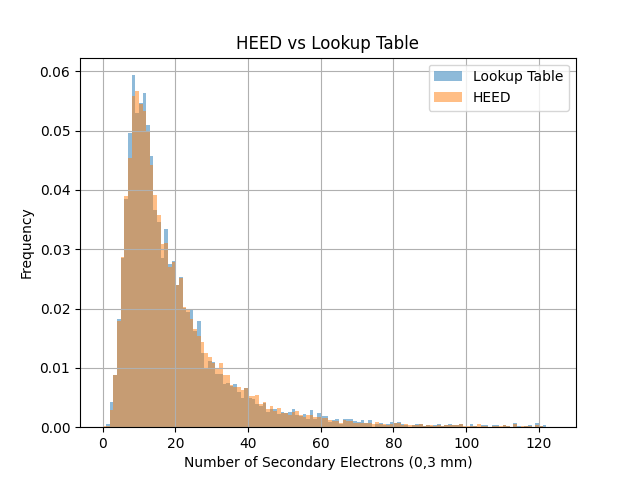

In [82]:
vals = []

for i in range(int(1e4)):
    vals.append(table[int(np.random.uniform(0, n))])

plt.figure()
plt.hist(vals, bins=np.arange(0, 125, 1), alpha=0.5, density=True,label='Lookup Table' )
plt.hist(n_elec_10, bins=np.arange(0,125,1), alpha=0.5, density=True, label='HEED')
plt.legend()
plt.grid()
plt.xlabel('Number of Secondary Electrons (0,3 mm)')
plt.ylabel('Frequency')
plt.title('HEED vs Lookup Table')


In [83]:
print(f"int table[] = {{")
for i in range(0, len(table), 100):
    line = table[i:i+100]
    print("    " + ", ".join(f"{x:.10g}" for x in line) + ("," if i + 100 < len(table) else ""))
print("};")

int table[] = {
    1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

np.float64(0.0)